In [24]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from LeNet import LeNet

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
# import visdom
from tensorboardX import SummaryWriter
import sys
import os

In [25]:
NORMALIZE = True

In [26]:
if NORMALIZE:
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
else:
    trans = transforms.Compose([
        transforms.ToTensor(),
    ])

In [27]:
data_home = '/data/winddy/'

train_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root=os.path.join(data_home, 'dataset/MNIST'), train=False, download=True, transform=trans)

In [28]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=2)

In [29]:
# 可视化数据集
def imshow(img):
#     img = img * 0.3081 + 0.1307
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

## 可视化：随机得到一些图片

In [30]:

dataiter = iter(train_loader)
images, labels = dataiter.next()

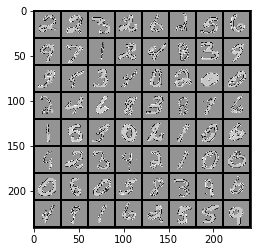

tensor([2, 2, 3, 2, 6, 2, 5, 6, 9, 7, 1, 2, 4, 8, 3, 9, 9, 5, 3, 4, 0, 2, 0, 0,
        2, 4, 6, 8, 3, 8, 1, 6, 1, 5, 3, 0, 2, 1, 0, 6, 9, 2, 3, 4, 2, 1, 0, 0,
        0, 6, 0, 5, 8, 3, 9, 6, 4, 9, 1, 6, 2, 5, 5, 9])


In [31]:
imshow(torchvision.utils.make_grid(images))
print(labels)

In [32]:
# vis = visdom.Visdom(env='train-mnist')

# vis.image(torchvision.utils.make_grid(images) * 0.3081 + 0.1307, win='train-image')

In [33]:
# tensorboardX
logdir_board = './logs/tensorboardX/'
if not os.path.exists(logdir_board):
    os.makedirs(logdir_board)
writer = SummaryWriter(log_dir=logdir_board, comment='_train_mnist')

## 训练网络

In [34]:
model = LeNet()

In [35]:
# 把模型添加进tensorboard
# dummy_input = torch.rand(4,1,28,28)
# writer.add_graph(model, (dummy_input))


In [36]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [37]:
learning_rate = 0.01
epochs = 10

In [38]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate, momentum=0.5)
loss_F = torch.nn.functional.cross_entropy

tmp_loss_arr = []

In [39]:
def train(model, device, train_loader, optimizer, loss_F, epoch, global_iter):
    model.train()
    running_loss = 0.0
    iter_count = 0
    
    for batch_idx, (data, target) in tqdm_notebook(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_F(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if batch_idx % 1000 == 999:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx*len(data), len(train_loader.dataset),
            100.*batch_idx/len(train_loader), loss.item()))
            
        if batch_idx % 200 == 199:
            global_iter += 1
#             print(global_iter)
            for name, param in model.named_parameters():
                writer.add_histogram(name, param.clone().cpu().data.numpy(), global_iter)
            
            tmp_one_hot = np.eye(10)[target.cpu().data.numpy()]
            writer.add_pr_curve('xoxo', tmp_one_hot, output)
            
            writer.add_scalar('loss_train', running_loss / 200, global_iter)
            tmp_loss_arr.append(running_loss / 200)
            running_loss = 0
#         if batch_idx % 200 == 0 and epoch==0:
#             train_loss = running_loss / 200
#             iter_count += 200
#             vis.line(Y=np.array([train_loss]), X=np.array([iter_count]),
#                      update='replace' if iter_count==200 else 'append',
#                      win='train-mnist-loss')

    
    return global_iter
            
def test(model, device, test_loader, loss_F):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_F(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [40]:
# loss_win = vis.line(np.arange(10))
global_iter = 0
for epoch in range(epochs):
    global_iter = train(model, device, train_loader, optimizer, loss_F, epoch, global_iter)
#     print(global_iter)
    test(model, device, test_loader, loss_F)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.1551, Accuracy: 9533/10000 (95%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0797, Accuracy: 9753/10000 (98%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0940, Accuracy: 9716/10000 (97%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0587, Accuracy: 9798/10000 (98%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0488, Accuracy: 9842/10000 (98%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0412, Accuracy: 9861/10000 (99%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0398, Accuracy: 9864/10000 (99%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0413, Accuracy: 9860/10000 (99%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0412, Accuracy: 9866/10000 (99%)



HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))



Test set: Average loss: 0.0365, Accuracy: 9880/10000 (99%)



In [41]:
## 保存模型
if not os.path.exists('./model'):
    os.makedirs('./model')
if NORMALIZE:
    model_path = './model/LeNet_MNIST.pt'
else:
    model_path = './model/LeNet_MNIST_unNormalize.pt'
torch.save(model.state_dict(), model_path)

In [21]:
tmp_loss_arr

[2.2983248138427737,
 2.273374855518341,
 1.5585584554076195,
 0.531488037481904,
 0.2980662427470088,
 0.25035486537963153,
 0.2192600278928876,
 0.175779587328434,
 0.14599430933594704,
 0.1466650810651481,
 0.1316159158013761,
 0.1206260035559535,
 0.10310211347416043,
 0.10359318478032947,
 0.09910686427727342,
 0.0891685520671308,
 0.07695446085184812,
 0.07819973103702069,
 0.09066054305061698,
 0.07921293554827571,
 0.07580988867208362,
 0.07400282876566053,
 0.06788804318755864,
 0.0722100168839097,
 0.06539380397647619,
 0.06585865672677756,
 0.05727605078369379,
 0.06022665392607451,
 0.05576694255694747,
 0.052877609934657815,
 0.055999457333236934,
 0.058988484162837265,
 0.05037900986149907,
 0.05325789177790284,
 0.048686838261783126,
 0.04699538828805089,
 0.04939619256183505,
 0.050805198829621076,
 0.04067203750833869,
 0.04370809564366937]

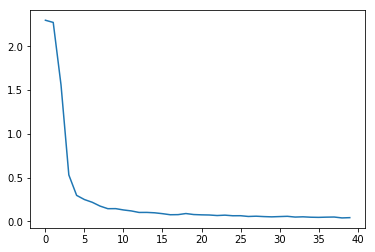

In [19]:
plt.plot(tmp_loss_arr)
plt.show()